## Understanding and Predicting Property Maintenance Fines

This assignment is based on a data challenge from the Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)). 

[Blight violations](http://www.detroitmi.gov/How-Do-I/Report/Blight-Complaint-FAQs) are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?

The first step in answering this question is understanding when and why a resident might fail to comply with a blight ticket. This is where predictive modeling comes in. For this assignment, your task is to predict whether a given blight ticket will be paid on time.
___

## Evaluation

Your predictions will be given as the probability that the corresponding blight ticket will be paid on time.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC). 

Your grade will be based on the AUC score computed for your classifier. A model which with an AUROC of 0.7 passes this assignment, over 0.75 will recieve full points.
___

In [1]:
# ! cat data/test.csv > test.csv
! cat data/train.csv > train.csv
! cat data/addresses.csv > addresses.csv
! cat data/latlons.csv > latlons.csv

In [2]:
import pandas as pd
import numpy as np

### Load data


    readonly/train.csv - the training set (all tickets issued 2004-2011)
    readonly/test.csv - the test set (all tickets issued 2012-2016)
    readonly/addresses.csv & readonly/latlons.csv - mapping from ticket id to addresses, and from addresses to lat/lon coordinates. 
    
The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible. Compliance, as well as a handful of other variables that will not be available at test-time, are only included in train.csv.

Note: All tickets where the violators were found not responsible are not considered during evaluation. They are included in the training set as an additional source of data for visualization, and to enable unsupervised and semi-supervised approaches. However, they are not included in the test set.    

### Load and preprocess train dataset

In [3]:
def load_csv(name):
    return pd.read_csv(name + ".csv", encoding='latin')

In [4]:
addresses = load_csv("addresses")
geo_loc = load_csv("latlons")

# this is the geolocation dataframe
address_and_geo = pd.merge(left=addresses, right=geo_loc, on='address', how='inner')

In [5]:
address_and_geo.head()

,ticket_id,address,lat,lon
0,22056,"2900 tyler, Detroit MI",42.390729,-83.124268
1,77242,"2900 tyler, Detroit MI",42.390729,-83.124268
2,77243,"2900 tyler, Detroit MI",42.390729,-83.124268
3,103945,"2900 tyler, Detroit MI",42.390729,-83.124268
4,138219,"2900 tyler, Detroit MI",42.390729,-83.124268


In [6]:
df = load_csv("train")

# keep only tickets where the violator is deemed responsible
df = df.loc[~df.compliance.isna()] 

/home/dcossao/.conda/envs/introDS/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (11,12,31) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [7]:
df = pd.merge(left=df, right=address_and_geo, how='left', on='ticket_id') 

After analysis of many different features, these were the selected columns

In [8]:
cols_to_keep = ([
    'fine_amount',
    'late_fee',
    'discount_amount',
    'address',
    'lat',
    'lon',
    'compliance'])

df = df.loc[:,cols_to_keep]

df['compliance'] = df.compliance.astype('bool') 

df.dtypes

fine_amount        float64
late_fee           float64
discount_amount    float64
address             object
lat                float64
lon                float64
compliance            bool
dtype: object

In [9]:
df.describe()

,fine_amount,late_fee,discount_amount,lat,lon
count,159880.000000,159880.000000,159880.000000,159878.000000,159878.000000
mean,357.035295,33.651512,0.195959,42.389747,-83.111530
std,675.655580,67.692916,4.290344,0.037120,0.093515
min,0.000000,0.000000,0.000000,42.145257,-84.403766
25%,200.000000,10.000000,0.000000,42.364536,-83.185854
50%,250.000000,25.000000,0.000000,42.392575,-83.124521
75%,250.000000,25.000000,0.000000,42.419160,-83.033202
max,10000.000000,1000.000000,350.000000,44.785389,-82.512936


#### Count how many violations there are in the same address. The hypothesis is that the more violations there are, the less likely people are to pay.

In [10]:
def add_num_violations(df):
    num_violations = df.address.value_counts()
    df['num_violations'] = df.apply(lambda row: num_violations.get(row['address']), axis=1)
    df = df.drop('address', axis=1)
    return df

In [11]:
df = add_num_violations(df)

In [12]:
df['num_violations'].describe()

count    159880.000000
mean          3.864736
std           3.498378
min           1.000000
25%           2.000000
50%           3.000000
75%           5.000000
max          52.000000
Name: num_violations, dtype: float64

#### Observations over the 3rd quantile of number of violations

In [13]:
'{:2.2%} of those with more than 5 violations complied with the fine'.format(df[df.num_violations > 5].compliance.sum()/df[df.num_violations > 5].shape[0])

'3.15% of those with more than 5 violations complied with the fine'

In [14]:
'{:2.2%} of those with 5 or less violations complied with the fine'.format(df[df.num_violations <= 5].compliance.sum()/df[df.num_violations <= 5].shape[0])

'8.34% of those with 5 or less violations complied with the fine'

In [15]:
def fill_na_lat_and_lon(df):
    values = {'lat': df.lat.mean(), 'lon': df.lon.mean()}        
    return df.fillna(value = values)

In [16]:
df = fill_na_lat_and_lon(df)

### Model
After trying different classifiers, logistic regression had the best performance.

In [17]:
y = df.compliance
X = df.drop(['compliance'], axis=1)

# check if X has maximal rank

from numpy.linalg import matrix_rank
matrix_rank(X.to_numpy()) == X.shape[1]

True

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [19]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [20]:
from sklearn.linear_model import LogisticRegression

lr_balanced= (LogisticRegression(random_state=0,
                        class_weight= 'balanced').fit(X_train_scaled, y_train))

#### Sanity check: is my predictor better than the Dummy Classifier?

In [21]:
from sklearn.metrics import classification_report

lr_predicted = lr_balanced.predict(X_test_scaled)

print(classification_report(y_test, lr_predicted, target_names=['not 1', '1']))

              precision    recall  f1-score   support

       not 1       0.97      0.71      0.82     37112
           1       0.16      0.70      0.26      2858

    accuracy                           0.71     39970
   macro avg       0.56      0.70      0.54     39970
weighted avg       0.91      0.71      0.78     39970



### Plot ROC curve

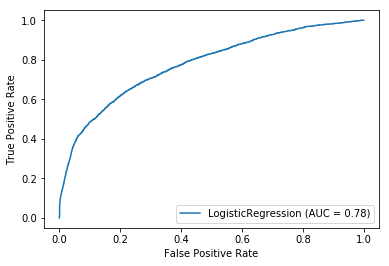

In [22]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(lr_balanced, X_test_scaled, y_test)

### Cross validation

In [23]:
from sklearn.model_selection import cross_val_score

scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

lr_clf= LogisticRegression(class_weight= 'balanced')

print('Cross-validation (AUC)', cross_val_score(lr_clf, X_scaled, y, cv=5, scoring = 'roc_auc'))

Cross-validation (AUC) [0.77071095 0.7731171  0.80015707 0.7659174  0.75289474]
